# Spaceship Titanic with Random Forest

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [653]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The Dataset

In [654]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('./input/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
# Display the first 5 examples
dataset_df.head(5)

Full train dataset shape is (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Observations:
- We have `'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'` as numerical features.
- `'CryoSleep', 'VIP'` are binary features.
- `HomePlanet', 'Destination'` are obvious categorical features.
- `'PassengerId', 'Cabin'` seems to be structured in some way.
- `'Name'` could potentially be split into `'Firstname', 'Surname'`.

In [655]:
# null or na checks
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Null values in the `'Age'` feature may have to be dealt with differently. Will leave them alone for now.

In [656]:
# fill na
dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
dataset_df[['HomePlanet', 'Destination']] = dataset_df[['HomePlanet', 'Destination']].fillna(value='Unknown')
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [657]:
# null or na checks
dataset_df.isnull().sum().sort_values(ascending=False)

Name            200
Cabin           199
Age             179
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

### Cabin Analysis
We will now split the `'Cabin'` column into three columns: `'Deck', 'Cabin_num', 'Side'`

In [658]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
dataset_df = dataset_df.drop('Cabin', axis=1)
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


Think we can consider all three as categorical features. We'll simply drop the nan rows from the dataset.

In [659]:
print("Deck:")
print(dataset_df.Deck.describe())
print(dataset_df.Deck.unique())
print("\n")
print("Cabin_num")
print(dataset_df.Cabin_num.dropna().describe())
print(dataset_df.Cabin_num.unique())
print("\n")
print("Side")
print(dataset_df.Side.describe())
print(dataset_df.Side.unique())

Deck:
count     8494
unique       8
top          F
freq      2794
Name: Deck, dtype: object
['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']


Cabin_num
count     8494
unique    1817
top         82
freq        28
Name: Cabin_num, dtype: object
['0' '1' '2' ... '1892' '1893' '1894']


Side
count     8494
unique       2
top          S
freq      4288
Name: Side, dtype: object
['P' 'S' nan]


That's a lot of people without names.

In [660]:
dataset_df = dataset_df.dropna(subset=['Deck', 'Cabin_num', 'Side'])
dataset_df.isnull().sum().sort_values(ascending=False)

Name            198
Age             175
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Deck              0
Cabin_num         0
Side              0
dtype: int64

### Name Analysis

In [661]:
dataset_df[["F_name", "S_name"]] = dataset_df["Name"].str.split(" ", expand=True)
dataset_df = dataset_df.drop(columns=['Name'])
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines


We can see some passengers share surnames.

In [662]:
print("F_name")
print(dataset_df.F_name.dropna().describe())
print(dataset_df.F_name.unique())
print("\n")
print("S_name")
print(dataset_df.S_name.describe())
print(dataset_df.S_name.unique())

dataset_df.S_name.value_counts()

F_name
count       8296
unique      2693
top       Dandra
freq          11
Name: F_name, dtype: object
['Maham' 'Juanna' 'Altark' ... 'Ants' 'Gian' 'Chain']


S_name
count          8296
unique         2208
top       Casonston
freq             17
Name: S_name, dtype: object
['Ofracculy' 'Vines' 'Susent' ... 'Fort' 'Workmanson' 'Sionerorly']


S_name
Casonston     17
Oneiles       16
Domington     15
Litthews      14
Browlerson    14
              ..
Dun            1
Witalnerod     1
Deryplinet     1
Rosargas       1
Sionerorly     1
Name: count, Length: 2208, dtype: int64

It seems poeple with shared surnames often have the same prefix in their passenger id.

In [663]:
casonston_df = dataset_df.loc[dataset_df['S_name'] == "Browlerson"]
casonston_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name
1118,1186_01,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,G,183,S,Card,Browlerson
1119,1186_02,Earth,False,TRAPPIST-1e,8.0,0,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Elany,Browlerson
1120,1186_03,Earth,True,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Harrie,Browlerson
1121,1186_04,Earth,False,TRAPPIST-1e,48.0,False,0.0,33.0,654.0,0.0,113.0,True,F,227,S,Oraryn,Browlerson
1122,1186_05,Earth,False,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Eriney,Browlerson
1857,1980_01,Earth,True,TRAPPIST-1e,3.0,False,0.0,0.0,0.0,0.0,0.0,True,G,312,S,Scotte,Browlerson
1859,1980_03,Earth,True,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,True,G,312,S,Penne,Browlerson
2661,2853_01,Earth,False,TRAPPIST-1e,20.0,False,56.0,757.0,111.0,0.0,0.0,True,F,544,S,Lonnez,Browlerson
4588,4890_01,Earth,False,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G,795,S,Rone,Browlerson
4589,4890_02,Earth,False,TRAPPIST-1e,23.0,False,0.0,0.0,874.0,0.0,0.0,True,F,932,S,Cline,Browlerson


### PassengerId Analysis

In [664]:
dataset_df[["PID_pre", "PID_suf"]] = dataset_df["PassengerId"].str.split("_", expand=True)
dataset_df = dataset_df.drop('PassengerId', axis=1)
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,PID_pre,PID_suf
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01


In [665]:
print("PID_pre")
print(dataset_df.PID_pre.dropna().describe())
print(dataset_df.PID_pre.unique())
print("\n")
print("PID_suf")
print(dataset_df.PID_suf.describe())
print(dataset_df.PID_suf.unique())

PID_pre
count     8494
unique    6118
top       5133
freq         8
Name: PID_pre, dtype: object
['0001' '0002' '0003' ... '9278' '9279' '9280']


PID_suf
count     8494
unique       8
top         01
freq      6083
Name: PID_suf, dtype: object
['01' '02' '03' '04' '05' '06' '07' '08']


We can make the assumption that for passengers without a `'Name'` may have the same surnmae as the most frequent `'S_name'` of their shared `'PID_pre'` which can be considered as `'Group'`. `'PID_suf'` seems to be unique to each group member.

In [666]:
casonston_df = dataset_df.loc[dataset_df['PID_pre'] == "5133"]
casonston_df.head(50)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,PID_pre,PID_suf
4808,Earth,False,55 Cancri e,36.0,False,0.0,0.0,846.0,0.0,0.0,True,G,829,P,Benry,Litthews,5133,01
4809,Earth,True,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,False,G,829,P,Hene,Litthews,5133,02
4810,Earth,True,PSO J318.5-22,NaN,False,0.0,0.0,0.0,0.0,0.0,True,G,829,P,Lina,Litthews,5133,03
4811,Earth,False,55 Cancri e,19.0,False,107.0,0.0,505.0,48.0,0.0,False,F,1046,P,Done,Litthews,5133,04
4812,Earth,False,TRAPPIST-1e,26.0,False,0.0,910.0,13.0,10.0,15.0,False,F,1046,P,Lynnon,Pugherman,5133,05
4813,Earth,True,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,G,829,P,Shanya,Josey,5133,06
4814,Earth,False,TRAPPIST-1e,26.0,False,1528.0,1.0,0.0,0.0,0.0,False,F,1046,P,NaN,NaN,5133,07
4815,Earth,False,TRAPPIST-1e,35.0,False,0.0,116.0,51.0,0.0,701.0,False,F,1046,P,Lawren,Josey,5133,08


In [667]:
dataset_df["Group"] = dataset_df.PID_pre
dataset_df["Group_id"] = dataset_df.PID_suf
dataset_df['Group_size'] = dataset_df.groupby('PID_pre')['PID_pre'].transform('count')
dataset_df = dataset_df.drop('PID_pre', axis=1)
dataset_df = dataset_df.drop('PID_suf', axis=1)

dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01,1


In [668]:
nameless_passengers = dataset_df.loc[(dataset_df.S_name.isna()) & (dataset_df.Group_size > 1)]

for i, x in nameless_passengers.iterrows():
  s_name = dataset_df.loc[dataset_df.Group == x.Group].S_name.value_counts().idxmax()
  dataset_df.loc[i, 'S_name'] = s_name

In [669]:
# Clearing F_name and S_name of nan
dataset_df[['F_name', 'S_name']] = dataset_df[['F_name', 'S_name']].fillna(value='Unknown')
dataset_df.isnull().sum().sort_values(ascending=False)

Age             175
HomePlanet        0
Transported       0
Group_id          0
Group             0
S_name            0
F_name            0
Side              0
Cabin_num         0
Deck              0
VRDeck            0
CryoSleep         0
Spa               0
ShoppingMall      0
FoodCourt         0
RoomService       0
VIP               0
Destination       0
Group_size        0
dtype: int64

Let's now consider group size.

<Axes: xlabel='Group_size', ylabel='count'>

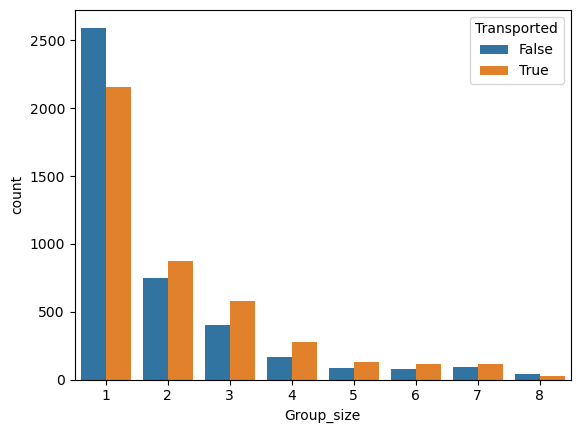

In [670]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Group_size', hue='Transported', ax=ax)

### Age Analysis

Text(0.5, 1.0, 'Transported for Age-less passengers')

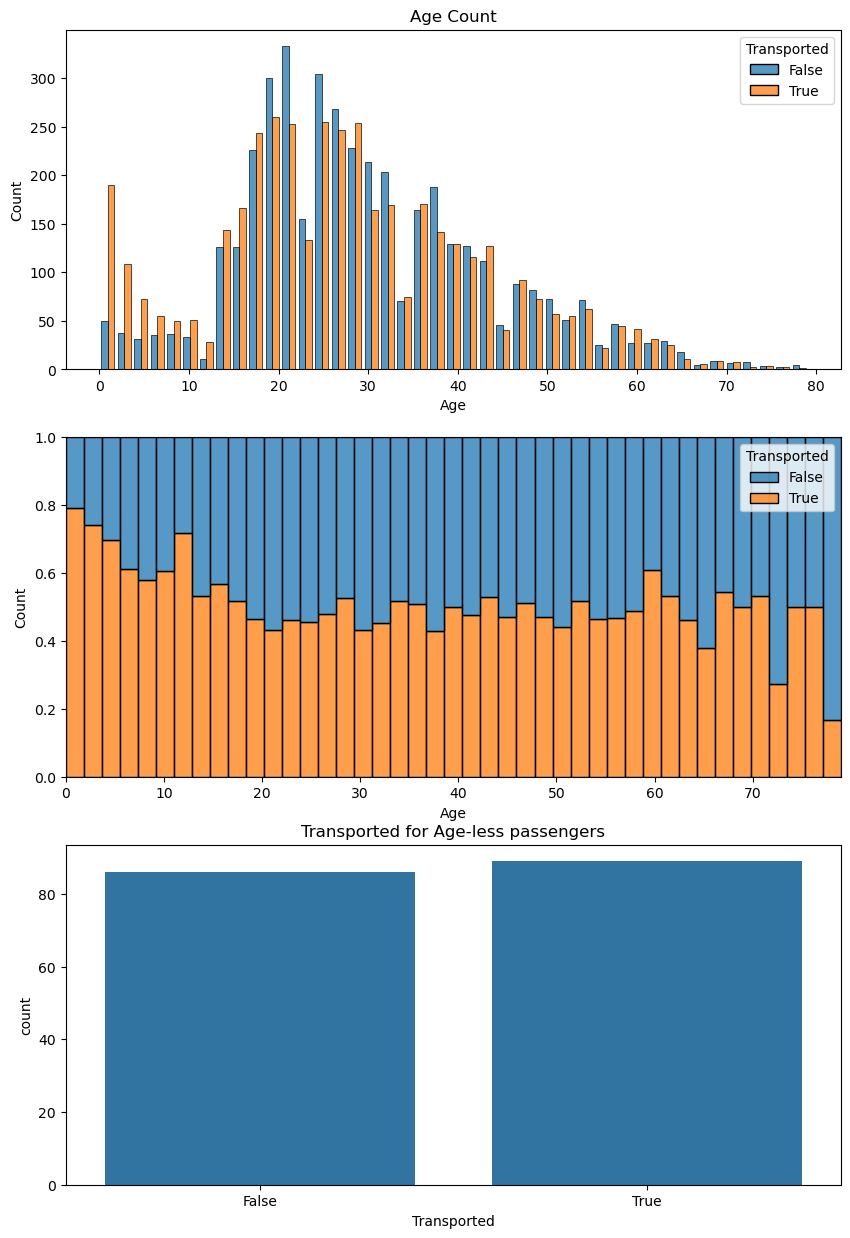

In [671]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 15)
sns.histplot(data=dataset_df.dropna(subset=['Age']), x='Age', hue='Transported', multiple='dodge', shrink=.8, ax=ax[0])
ax[0].set_title('Age Count')

sns.histplot(data=dataset_df.dropna(subset=['Age']), x='Age', hue='Transported', multiple='fill', ax=ax[1])

sns.countplot(data=dataset_df.loc[dataset_df.Age.isna()], x='Transported', ax=ax[2])
ax[2].set_title('Transported for Age-less passengers')

Observations: 
- It seems passengers of age $\lt 13$ are likelier to be transported than passengers $\gt 12$. We could potentially adjust this later and compare the results.
- Whether or not the passenger's age is known doesn't seem to affect their chance of being transported.

In [672]:
dataset_df = dataset_df.dropna(subset=['Age']) # drop null Age passengers

dataset_df['Age_gt12'] = dataset_df.Age.apply(lambda x: x > 12)
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size,Age_gt12
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01,1,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01,1,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01,2,True
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02,2,True
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01,1,True


<Axes: xlabel='Age_gt12', ylabel='count'>

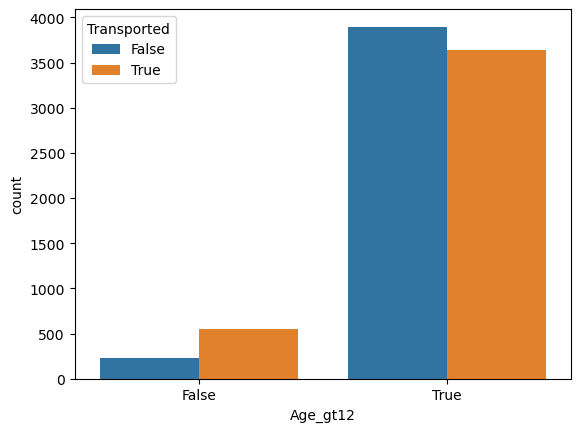

In [673]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Age_gt12', hue='Transported')

### Destination Analysis

In [674]:
dataset_df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', 'Unknown'],
      dtype=object)

In [675]:
dest_dict = {'TRAPPIST-1e': 'T', 'PSO J318.5-22': 'P', '55 Cancri e': 'C', 'Unknown': 'U'}
dataset_df.Destination = dataset_df.Destination.map(dest_dict)

<Axes: xlabel='Destination', ylabel='count'>

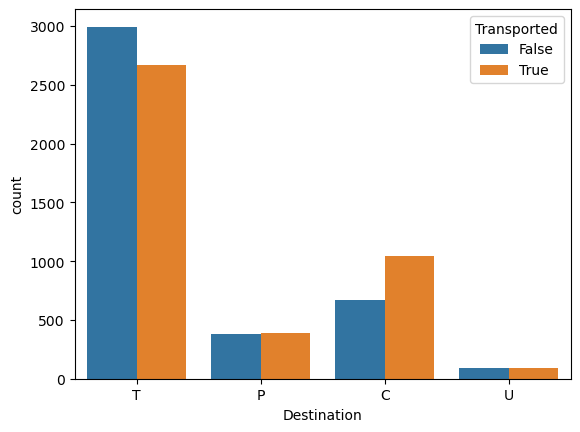

In [676]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Destination', hue='Transported')

Nothing much here, other than most passengers headed towards `'TRAPPIST-1e'`.

### Analyzing Numericals

In [677]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for figure in numerical_features:
  print(dataset_df[figure].describe())
  print("\n")

count    8319.000000
mean      218.421685
std       637.786857
min         0.000000
25%         0.000000
50%         0.000000
75%        42.000000
max      9920.000000
Name: RoomService, dtype: float64


count     8319.000000
mean       449.125736
std       1603.280944
min          0.000000
25%          0.000000
50%          0.000000
75%         63.500000
max      29813.000000
Name: FoodCourt, dtype: float64


count     8319.000000
mean       171.907561
std        606.232248
min          0.000000
25%          0.000000
50%          0.000000
75%         23.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


count     8319.000000
mean       298.873903
std       1102.315342
min          0.000000
25%          0.000000
50%          0.000000
75%         54.000000
max      22408.000000
Name: Spa, dtype: float64


count     8319.000000
mean       300.040029
std       1141.453862
min          0.000000
25%          0.000000
50%          0.000000
75%         41.000000
max      24133.

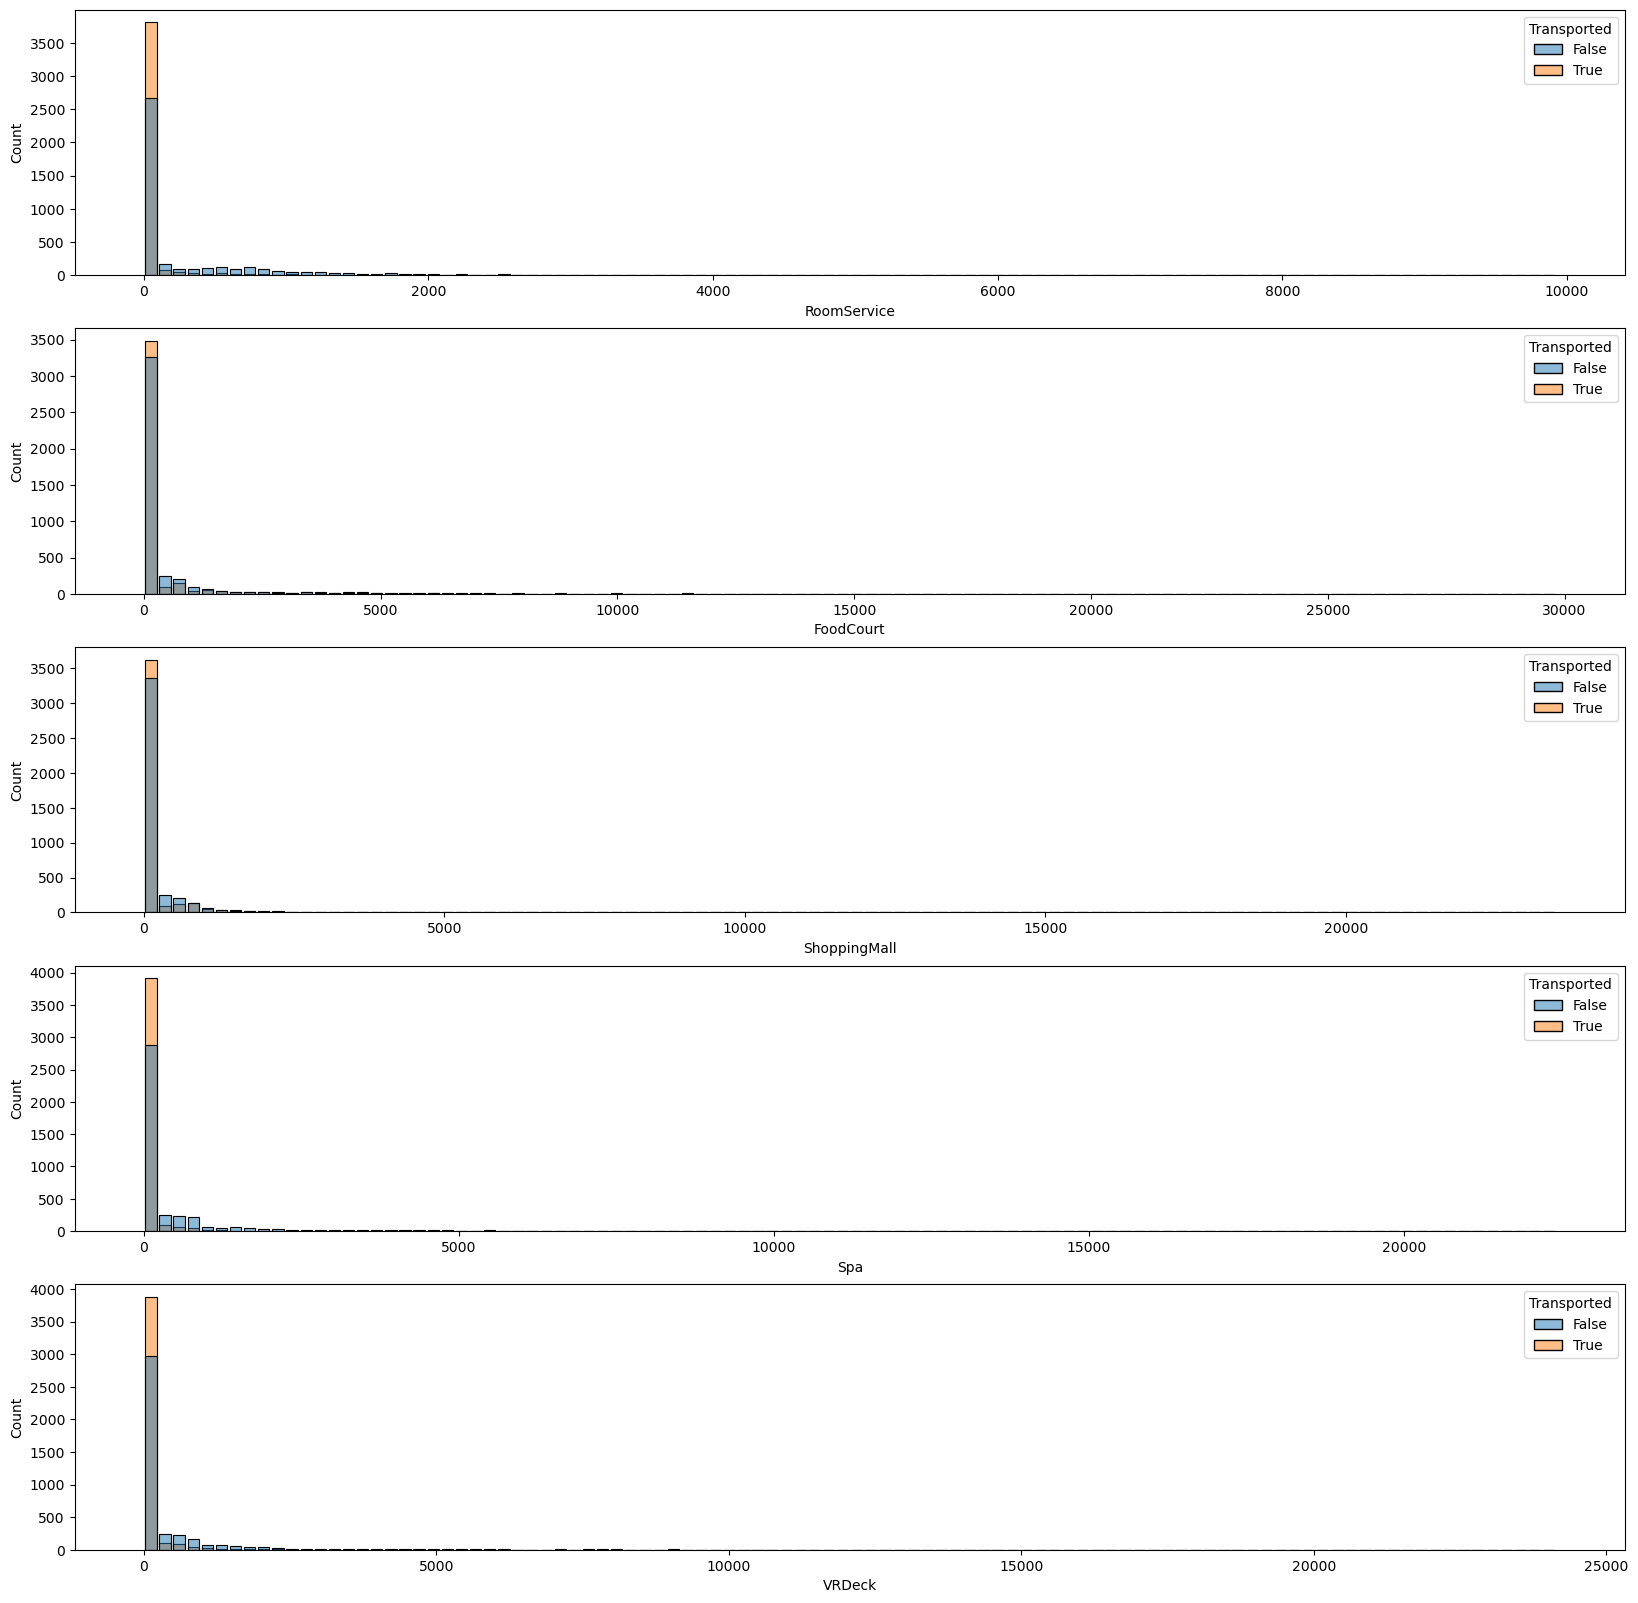

In [678]:
fig, ax = plt.subplots(len(numerical_features),1)
fig.set_size_inches(20,20)
for i, feature in enumerate(numerical_features):
  sns.histplot(data=dataset_df, x=feature, hue='Transported', bins=100, shrink=.8, ax=ax[i])

It seems like passengers who have spent less on amenities have a higher chance on getting transported. We may want to separate passengers who have spent very little.

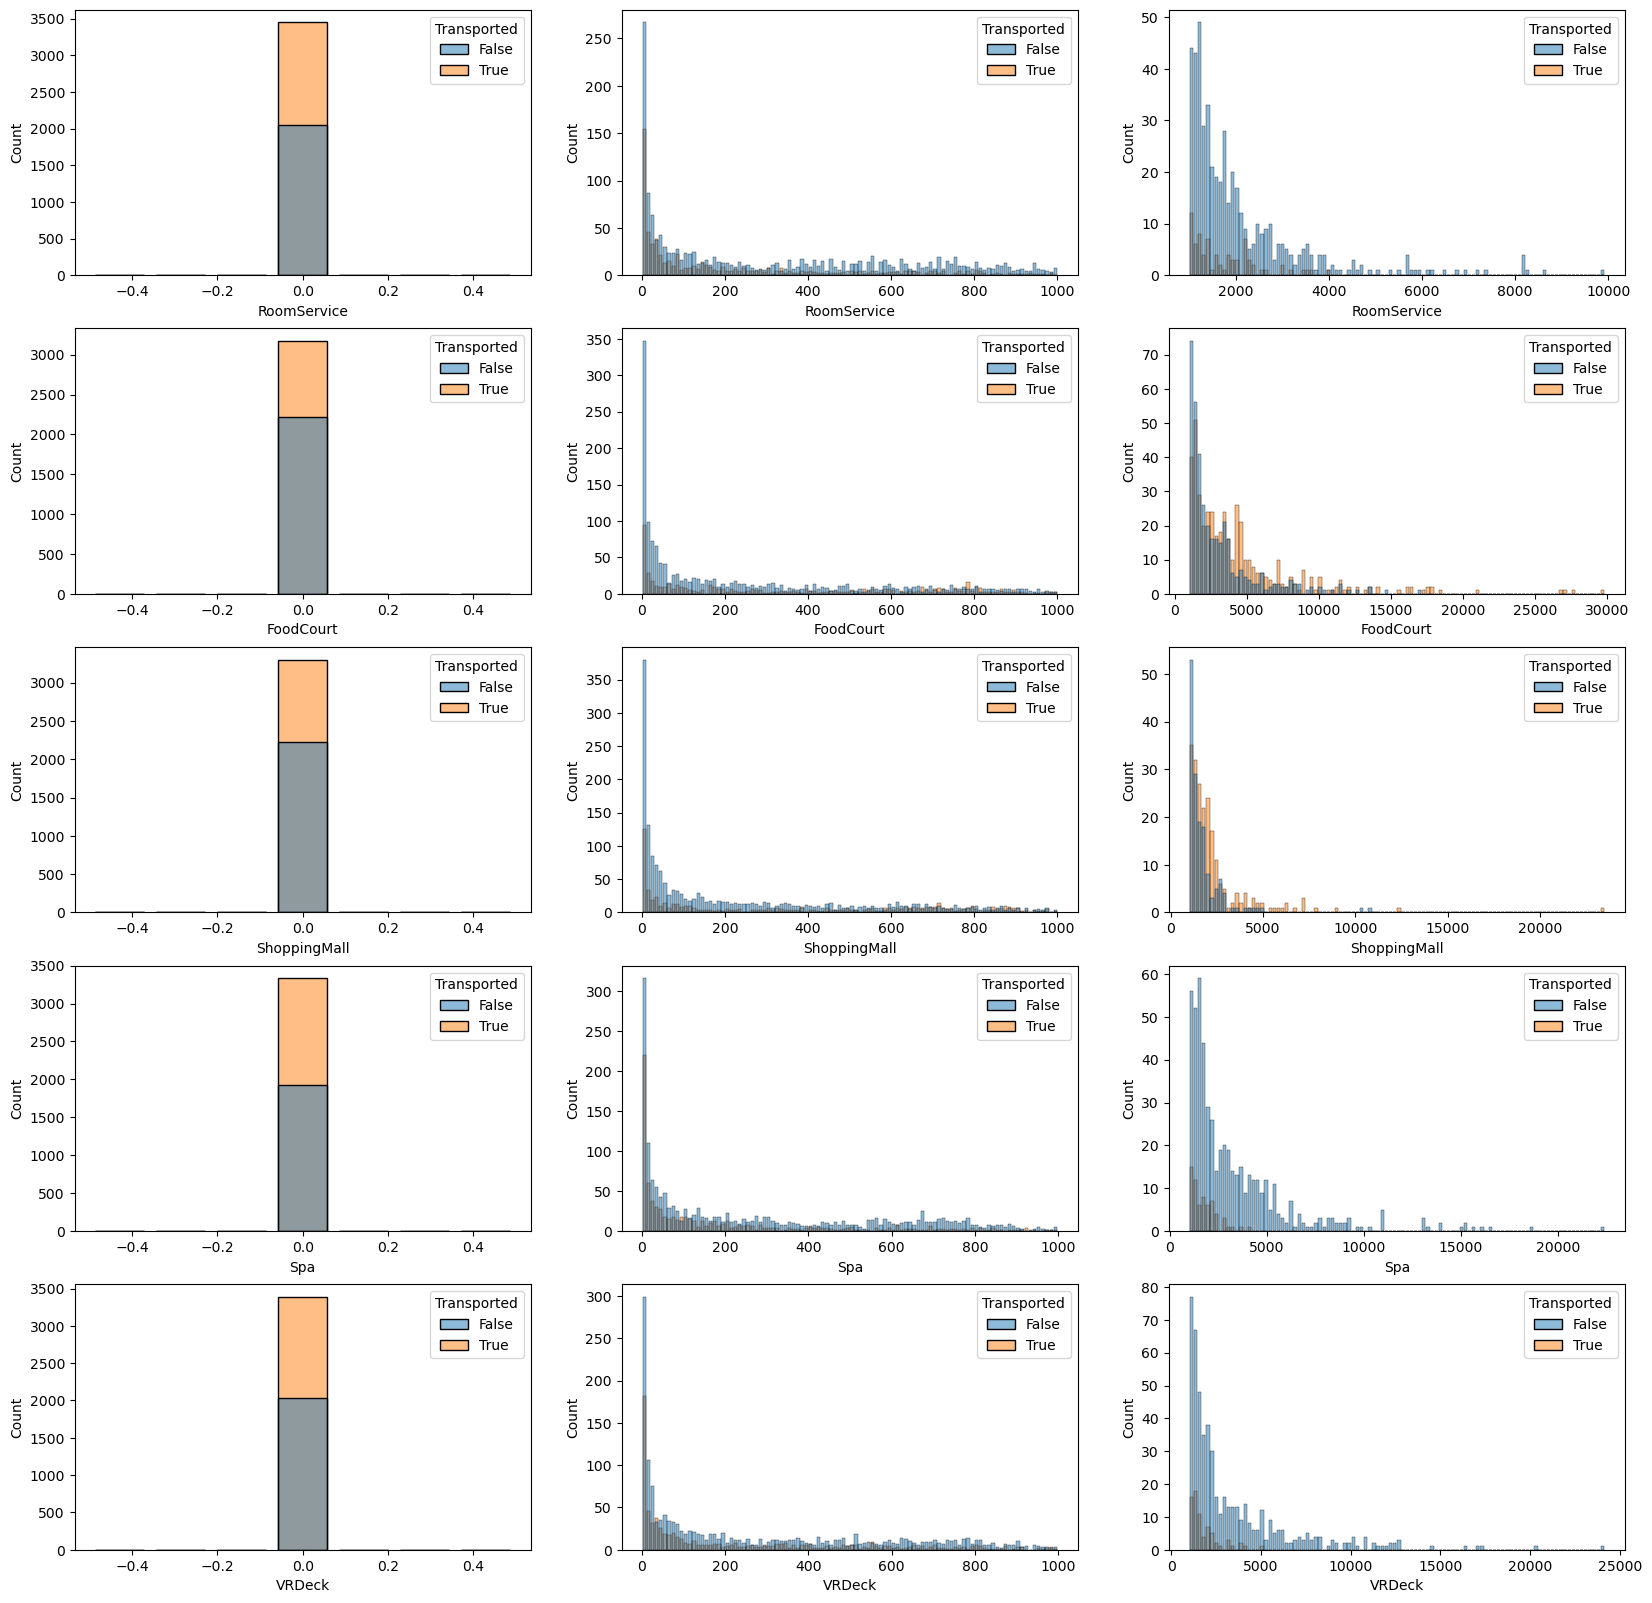

In [679]:
fig, ax = plt.subplots(len(numerical_features),3)
fig.set_size_inches(20,20)
for i, feature in enumerate(numerical_features):
  sns.histplot(data=dataset_df.loc[dataset_df[feature]==0], x=feature, hue='Transported', bins=7, shrink=.8, ax=ax[i][0])
  sns.histplot(data=dataset_df.loc[(dataset_df[feature]<=1000) & (dataset_df[feature]>0)], x=feature, hue='Transported', bins=100, shrink=.8, ax=ax[i][1])
  sns.histplot(data=dataset_df.loc[dataset_df[feature]>1000], x=feature, hue='Transported', bins=100, shrink=.8, ax=ax[i][2])

The rest we can just bin into maybe four categories.

In [680]:
# binning range
binning_map = {'RoomService': [-1,1,1000,4000,10000], 'FoodCourt':[-1,1,1000,5000,30000], 'ShoppingMall':[-1,1,1000,4000,30000], 'Spa':[-1,1,1000,5000,30000], 'VRDeck':[-1,1,1000,5000,25000]}

for i, feature in enumerate(numerical_features):
  dataset_df[feature+'_bin'] = pd.cut(dataset_df[feature], bins=binning_map[feature], labels=['a','b','c','d'])
  
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,S_name,Group,Group_id,Group_size,Age_gt12,RoomService_bin,FoodCourt_bin,ShoppingMall_bin,Spa_bin,VRDeck_bin
0,Europa,False,T,39.0,False,0.0,0.0,0.0,0.0,0.0,...,Ofracculy,0001,01,1,True,a,a,a,a,a
1,Earth,False,T,24.0,False,109.0,9.0,25.0,549.0,44.0,...,Vines,0002,01,1,True,b,b,b,b,b
2,Europa,False,T,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,Susent,0003,01,2,True,b,c,a,d,b
3,Europa,False,T,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,Susent,0003,02,2,True,a,c,b,c,b
4,Earth,False,T,16.0,False,303.0,70.0,151.0,565.0,2.0,...,Santantines,0004,01,1,True,b,b,b,b,b


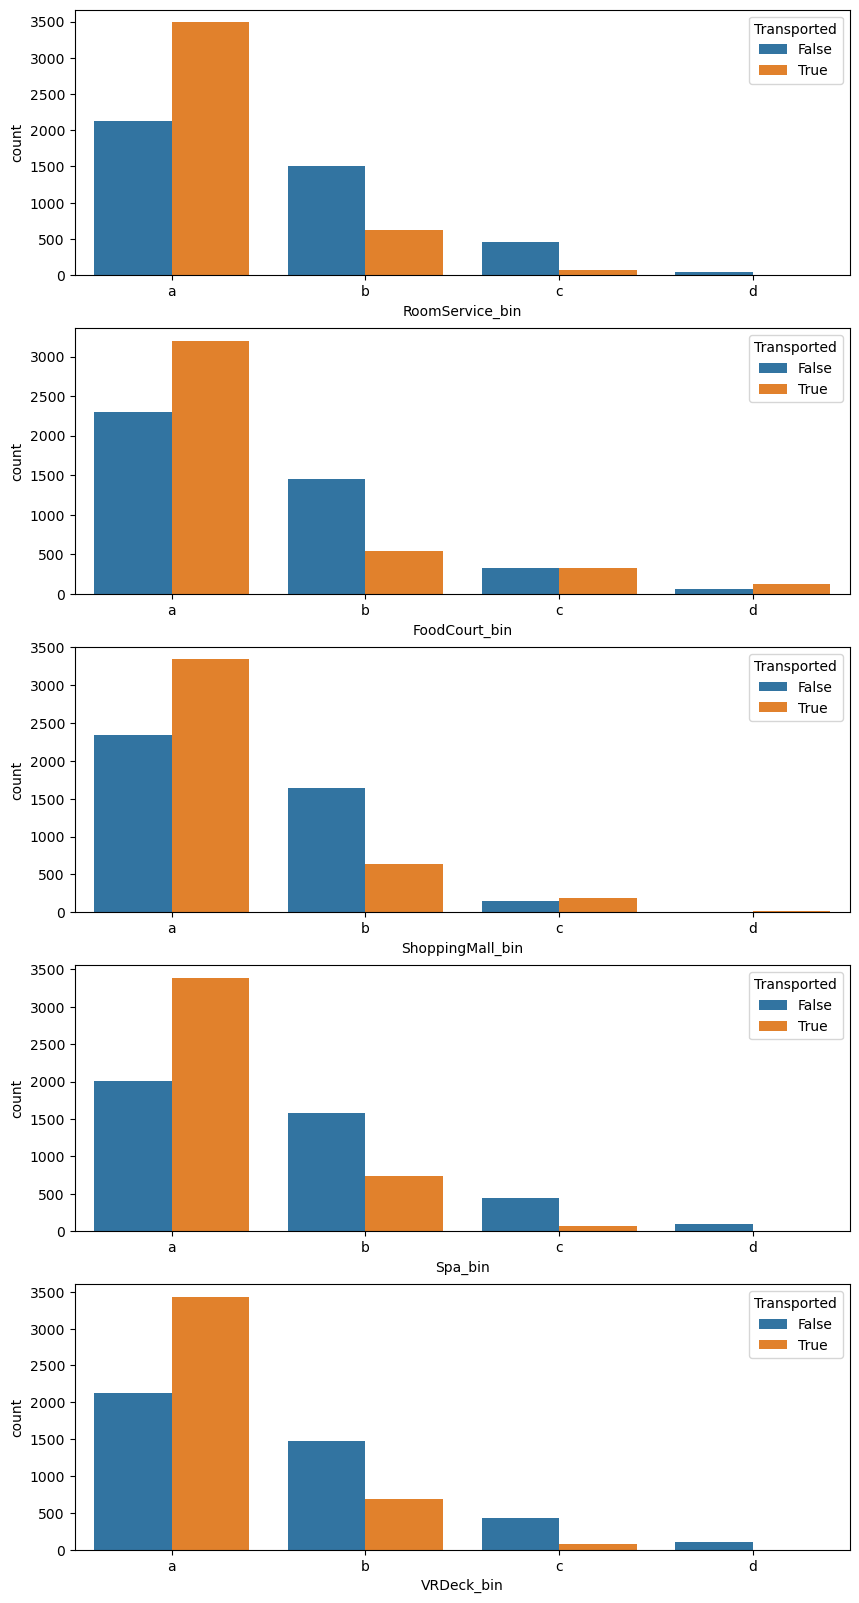

In [681]:
fig, ax = plt.subplots(len(numerical_features),1)
fig.set_size_inches(10,20)
for i, feature in enumerate(numerical_features):
  sns.countplot(data=dataset_df, x=feature+'_bin', hue='Transported', ax=ax[i])

### Convert Booleans to Integers

In [682]:
# Convert Bool to Int
dataset_df.Side = dataset_df.Side.apply(lambda x: True if x == 'P' else False)
dataset_df[['CryoSleep','VIP','Transported', 'Side']] = dataset_df[['CryoSleep','VIP','Transported', 'Side']].astype(int)

In [683]:
dataset_df = dataset_df.drop(columns=numerical_features)
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size,Age_gt12,RoomService_bin,FoodCourt_bin,ShoppingMall_bin,Spa_bin,VRDeck_bin
0,Europa,0,T,39.0,0,0,B,0,1,Maham,Ofracculy,0001,01,1,True,a,a,a,a,a
1,Earth,0,T,24.0,0,1,F,0,0,Juanna,Vines,0002,01,1,True,b,b,b,b,b
2,Europa,0,T,58.0,1,0,A,0,0,Altark,Susent,0003,01,2,True,b,c,a,d,b
3,Europa,0,T,33.0,0,0,A,0,0,Solam,Susent,0003,02,2,True,a,c,b,c,b
4,Earth,0,T,16.0,0,1,F,1,0,Willy,Santantines,0004,01,1,True,b,b,b,b,b


### Apply the Same to the Test Data

Seems we won't have to worry about null values.

In [684]:
test_df = pd.read_csv('./input/test.csv')
# null or na checks
dataset_df.isnull().sum().sort_values(ascending=False)

HomePlanet          0
CryoSleep           0
Spa_bin             0
ShoppingMall_bin    0
FoodCourt_bin       0
RoomService_bin     0
Age_gt12            0
Group_size          0
Group_id            0
Group               0
S_name              0
F_name              0
Side                0
Cabin_num           0
Deck                0
Transported         0
VIP                 0
Age                 0
Destination         0
VRDeck_bin          0
dtype: int64

In [685]:
# fill na
test_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = test_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
test_df[['HomePlanet', 'Destination']] = test_df[['HomePlanet', 'Destination']].fillna(value='Unknown')
# 
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)
test_df = test_df.dropna(subset=['Deck', 'Cabin_num', 'Side'])
#
test_df[["F_name", "S_name"]] = test_df["Name"].str.split(" ", expand=True)
test_df = test_df.drop(columns=['Name'])
#
test_df[["Group", "Group_id"]] = test_df["PassengerId"].str.split("_", expand=True)
test_df = test_df.drop('PassengerId', axis=1)
test_df['Group_size'] = test_df.groupby('Group')['Group_id'].transform('count')
#
nameless_passengers = test_df.loc[(test_df.S_name.isna()) & (test_df.Group_size > 1)]
for i, x in nameless_passengers.iterrows():
  s_name = test_df.loc[test_df.Group == x.Group].S_name.value_counts().idxmax()
  test_df.loc[i, 'S_name'] = s_name
# Clearing F_name and S_name of nan
test_df[['F_name', 'S_name']] = test_df[['F_name', 'S_name']].fillna(value='Unknown')
test_df.isnull().sum().sort_values(ascending=False)
#
test_df = test_df.dropna(subset=['Age']) # drop null Age passengers
test_df['Age_gt12'] = test_df.Age.apply(lambda x: x > 12)
#
test_df.Destination = test_df.Destination.map(dest_dict)
#
for i, feature in enumerate(numerical_features):
  test_df[feature+'_bin'] = pd.cut(test_df[feature], bins=binning_map[feature], labels=['a','b','c','d'])
test_df = test_df.drop(columns=numerical_features)
# Convert Bool to Int
test_df.Side = test_df.Side.apply(lambda x: True if x == 'P' else False)
test_df[['CryoSleep','VIP', 'Side']] = test_df[['CryoSleep','VIP', 'Side']].astype(int)
#
test_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size,Age_gt12,RoomService_bin,FoodCourt_bin,ShoppingMall_bin,Spa_bin,VRDeck_bin
0,Earth,1,T,27.0,0,G,3,0,Nelly,Carsoning,0013,01,1,True,a,a,a,a,a
1,Earth,0,T,19.0,0,F,4,0,Lerome,Peckers,0018,01,1,True,a,b,a,c,a
2,Europa,1,C,31.0,0,C,0,0,Sabih,Unhearfus,0019,01,1,True,a,a,a,a,a
3,Europa,0,T,38.0,0,C,1,0,Meratz,Caltilter,0021,01,1,True,a,d,a,b,b
4,Earth,0,T,20.0,0,F,5,0,Brence,Harperez,0023,01,1,True,b,a,b,a,a


## Training Random Forest with Scikitlearn

In [686]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [692]:
X = dataset_df.drop(columns=['Transported', 'F_name'])
y = dataset_df.Transported

In [693]:
encoder = OneHotEncoder(drop='if_binary')

categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Cabin_num', 'Side', 'S_name', 'Group', 'Group_id', 'Group_size', 'Age_gt12', 'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin', 'VRDeck_bin']

new_categorical_features = encoder.fit_transform(X[categorical_features])
new_categorical_features = pd.DataFrame(new_categorical_features.toarray(), columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X = pd.concat([X.drop(columns=categorical_features),new_categorical_features], axis=1)
X.head(5)

,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,CryoSleep_1,Destination_C,Destination_P,Destination_T,Destination_U,...,ShoppingMall_bin_c,ShoppingMall_bin_d,Spa_bin_a,Spa_bin_b,Spa_bin_c,Spa_bin_d,VRDeck_bin_a,VRDeck_bin_b,VRDeck_bin_c,VRDeck_bin_d
0,39.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,58.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [694]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1, stratify=y)

In [701]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(random_state=1, max_depth=5)

clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7709992486851991

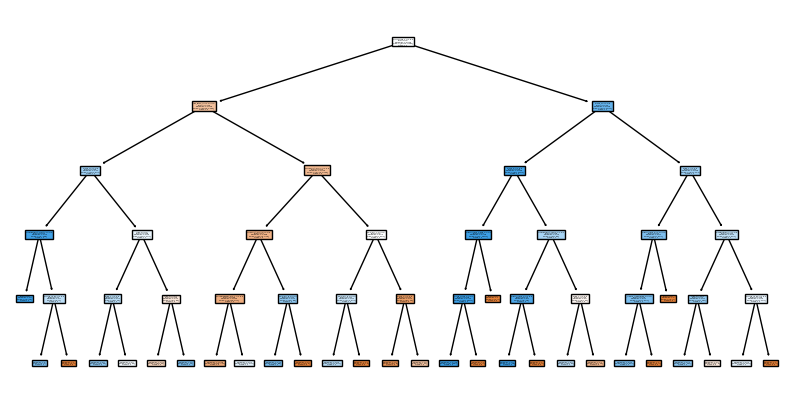

In [702]:
plt.figure(figsize=(10,5))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=y.unique().astype(str))
plt.show()

In [703]:
clf.score(X_test, y_test)

0.7530048076923077

In [700]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    random_state=99,
    loss='log_loss',
    learning_rate=.01,
    n_estimators=400,
    max_depth=5)

gbc.fit(X_train, y_train)
gbc.score(X_train, y_train)

/home/dyk3878/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8054094665664914

In [704]:
gbc.score(X_test, y_test)

0.7740384615384616